# Many to many models

***import library***

In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

import os
import datetime
from math import sqrt

import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Dropout, Flatten
from keras.layers import  regularizers

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
import tensorflow.keras.backend as K
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


***import data***

In [2]:


#import data
data = pd.read_csv("../VIDEO TRAFFIC/FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])


In [3]:
data.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,16,533.33333,I,237784,52.353,52.474,52.951
1,13,433.33333,B,191888,48.114,49.612,50.446
2,14,466.66667,B,198992,48.003,49.608,50.231
3,15,500.00000,B,136112,48.290,50.312,51.118
4,20,666.66667,P,296416,49.951,50.910,51.201


In [4]:
data.dropna(0,inplace= True)

In [5]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)

data.drop(('x'), axis=1, inplace=True)
data.drop(('y'), axis=1, inplace=True)
data.drop(('z'), axis=1, inplace=True)

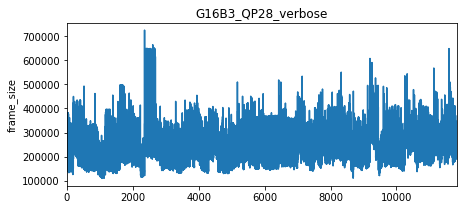

In [6]:
frame_size = data.frame_size
plt.figure(figsize= (7,3))
frame_size.plot()
plt.title("G16B3_QP28_verbose")
plt.ylabel("frame_size")
plt.show()

In [7]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [8]:
data.head(5)

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
1,433.33333,0,191888
2,466.66667,0,198992
3,500.00000,0,136112
4,666.66667,2,296416


In [9]:
# data labels
labels_index = { "B" : 0, "I" : 1, "P" : 2} 

In [10]:
indexNames1 = data[data['video_frame'] == 0 ].index

# Delete these row indexes from dataFrame
data.drop(indexNames1 , inplace=True)

In [11]:
data.head()

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
4,666.66667,2,296416
8,800.00000,2,289312
12,933.33333,2,288384
16,1066.66667,1,259272


In [12]:
data.frame_size.dropna(0, inplace=True)
dataset = data.frame_size.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset.shape

(2962,)

In [13]:
dataset = pd.DataFrame(dataset)
print(dataset.shape)

(2962, 1)


In [14]:
# *****************split into train and test sets********************

test_split = int(len(dataset) * 0.8)
X_train = dataset[:test_split]
y_train = dataset [:test_split]
X_test = dataset[test_split:]
y_test = dataset[test_split:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2369, 1) (2369, 1) (593, 1) (593, 1)


In [15]:
#---NORMALIZE DATA---

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2369, 1) (2369, 1)
(593, 1) (593, 1)


***Define parameters***

In [16]:

# num of input signals
#input_dim = X_train.shape[1]
# num of output signals
#output_dim = y_train.shape[1]


input_seq_len = 16
output_seq_len = 8
num_input_features = 1
num_output_features = 1
batch_size = 10


In [17]:

def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],num_input_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],num_output_features))
    
    return input_seq, output_seq

In [18]:
input_seq, output_seq = generate_train_sequences(X_train)
print(input_seq.shape, output_seq.shape)

(2345, 16, 1) (2345, 8, 1)


***Encoder***

In [19]:
# Define an input series and encode it with an LSTM. 

encoder_inputs = tf.keras.layers.Input(shape=(None, num_input_features)) 
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

***Decoder***

In [20]:
# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = tf.keras.layers.Input(shape=(None, 1)) 


# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(128,  return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
unified_lstm (UnifiedLSTM)      [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
unified_lstm_1 (UnifiedLSTM)    [(None, None, 128),  66560       input_2[0][0]                    
                                                                 unified_lstm[0][1]           

In [21]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer= optimizer, metrics=[ 'mse'])

In [22]:
input_seq, output_seq = generate_train_sequences(X_train)

encoder_input_data = input_seq
decoder_target_data = output_seq
decoder_input_data = np.zeros(decoder_target_data.shape)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs= 100,
                             validation_split=0.1, 
                             shuffle=False)

Train on 2110 samples, validate on 235 samples
Epoch 1/100
2110/2110 [==============================] - 3s 1ms/sample - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0569 - val_mse: 0.0569
Epoch 2/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0544 - mse: 0.0544 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 3/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 4/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0564 - val_mse: 0.0564
Epoch 5/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 6/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 7/100
2110/2110 [==============================] - 2s 1ms/sample - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0557 - val_mse: 0

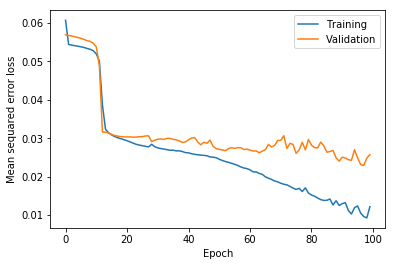

In [23]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model Loss')
plt.ylabel('Mean sequared error loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


***Inference model***

In [24]:
# define inference encoder
n_units = 128

encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
    
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

***Prediction***

In [25]:
def predict(x, encoder_model, decoder_model, num_steps_to_predict):
    
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_model.predict([decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [26]:
def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [27]:
X_test, y_test = generate_test_samples()
print(X_test.shape, y_test.shape)

(569, 16, 1) (569, 8, 1)


In [28]:
#from utils import plot_prediction
num_steps_to_predict = 8

y_test_predicted = predict(X_test, encoder_model, decoder_model, num_steps_to_predict)
y_test_predicted.shape

(569, 8, 1)

In [29]:
y_test.shape

(569, 8, 1)

***Plotting***

In [30]:
y_test_predicted = y_test_predicted.reshape(y_test_predicted.shape[0], y_test_predicted.shape[1])
y_test_predicted_inv = scaler.inverse_transform(y_test_predicted)

y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test_inv = scaler.inverse_transform(y_test)


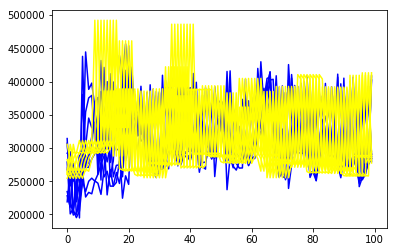

In [31]:

plt.plot(y_test_predicted_inv[:100], label = "pred", color ='blue')
plt.plot(y_test_inv[:100], label = "actual", color= 'yellow')
plt.show()

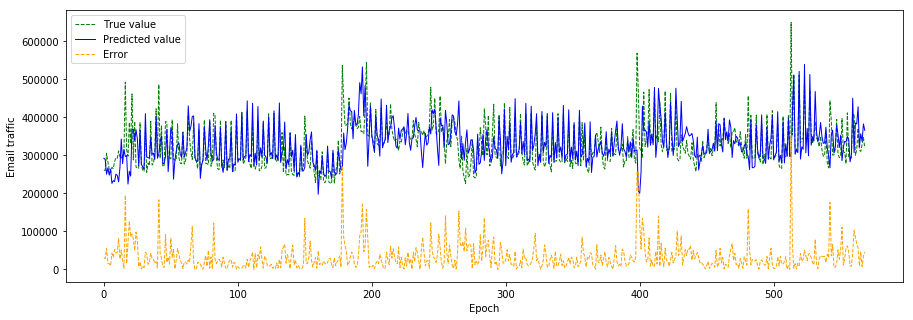

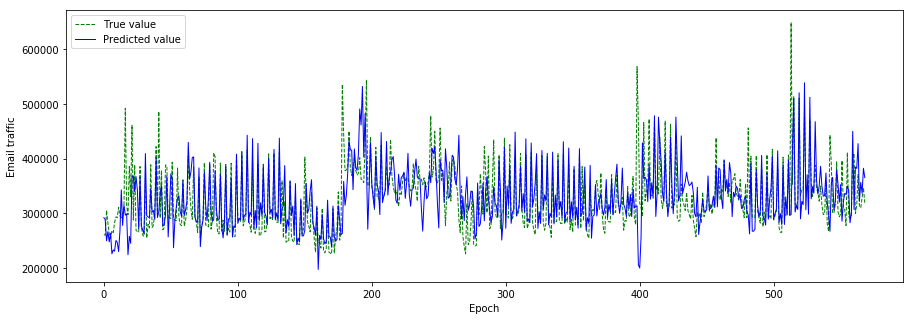

In [32]:
#********************* Actual value, Predicted value and Prediction Error ***************

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot(y_test_inv[:,0], label="True value", linewidth=1,linestyle="--",color= 'green')
plt.plot(y_test_predicted_inv[:,0], label="Predicted value", linewidth=1,color='blue')

error = abs(y_test_inv[:,0] - y_test_predicted_inv[:,0])

plt.plot(error, label='Error',color= 'orange', linewidth=1, linestyle="--")
plt.legend()
plt.show()

#******************************* True value vs Prediction **********************/

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot (y_test_inv[:,0], label="True value", linewidth=1,color= 'green', linestyle="--")
plt.plot(y_test_predicted_inv[:,0], label="Predicted value", linewidth=1,color='blue')
plt.legend()
plt.show()

***Performance Evaluation metrics***

In [33]:

models = pd.DataFrame(index=['MAPE','MAE'], 
                      columns=['seq2seq', 'LSTM_many_to_many','CNN_many_to_many', 'LSTM_many_to_one', 'CNN_many_to_one'])

In [34]:
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error

#def rpe1(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return np.mean(y_true - y_pred)/y_true * 100


def mean_absolute_error1(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) * 100


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#models.loc['rmse','seq2seq'] = np.sqrt(mean_squared_error(y_test, y_test_predicted))
models.loc['MAPE','seq2seq'] = mean_absolute_percentage_error(y_test, y_test_predicted)
models.loc['MAE', 'seq2seq'] = mean_absolute_error(y_test, y_test_predicted)*100
#models.loc['mae2', 'seq2seq'] = mean_absolute_error1(y_test, y_test_predicted)


# Prediction Time !!!!
mse = round(mean_squared_error(y_test, y_test_predicted), 2)
print('MSE', mse)
rmse = round(sqrt(mse), 2)
print('RMSE', rmse)

MSE 0.04
RMSE 0.2


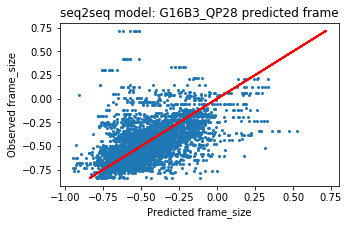

In [35]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter((y_test_predicted), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('seq2seq model: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# Multistep model

In [36]:

#import data
data2 = pd.read_csv("../VIDEO TRAFFIC/FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [37]:
data2.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,16,533.33333,I,237784,52.353,52.474,52.951
1,13,433.33333,B,191888,48.114,49.612,50.446
2,14,466.66667,B,198992,48.003,49.608,50.231
3,15,500.00000,B,136112,48.290,50.312,51.118
4,20,666.66667,P,296416,49.951,50.910,51.201


In [38]:
data2.dropna(0,inplace= True)

In [39]:
#drop decoded frame column
data2.drop(('decoded_frame'), axis=1, inplace=True)

data2.drop(('x'), axis=1, inplace=True)
data2.drop(('y'), axis=1, inplace=True)
data2.drop(('z'), axis=1, inplace=True)

In [40]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data2['video_frame'])
print(list(le.classes_))
data2['video_frame'] = le.transform(data2['video_frame'])

['B', 'I', 'P']


In [41]:
data2.head(5)

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
1,433.33333,0,191888
2,466.66667,0,198992
3,500.00000,0,136112
4,666.66667,2,296416


In [42]:
# data labels
labels_index = { "B" : 0, "I" : 1, "P" : 2} 

In [43]:
indexNames1 = data2[data2['video_frame'] == 0 ].index

# Delete these row indexes from dataFrame
data2.drop(indexNames1 , inplace=True)

In [44]:
data2.head()

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
4,666.66667,2,296416
8,800.00000,2,289312
12,933.33333,2,288384
16,1066.66667,1,259272


In [45]:
data2.frame_size.dropna(0, inplace=True)

In [46]:
dataset2 = data2.frame_size.values #numpy.ndarray
data2 = data2.astype ('float32')
#dataset = dataset.astype('float32')
dataset2.shape

(2962,)

In [47]:
dataset2 = pd.DataFrame(dataset2)
print(dataset2.shape)

(2962, 1)


In [48]:
# *****************split into train and test sets********************

test_split = int(len(dataset2) * 0.8)

train2 = dataset2[:test_split]
test2 = dataset2[test_split:]

In [49]:
#********Data normalization**************************

scaler = MinMaxScaler(feature_range=(-1, 1))

train2 = scaler.fit_transform(train2)
test2= scaler.transform(test2)

In [50]:
#****************************Create lagged time series dataset*******************

def prepare_seq2seq_data(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_ahead):
        input_seq = dataset[i:(i + look_back)]
        output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
        dataX.append(input_seq)
        dataY.append(output_seq)

    dataX = np.reshape(np.array(dataX),[-1,look_back])
    dataY = np.reshape(np.array(dataY),[-1,look_ahead])
    #print (dataY.shape)
    return dataX,dataY

In [51]:
look_back = 16
look_ahead = 8

X_train, y_train = prepare_seq2seq_data(train2, look_back, look_ahead)
X_test, y_test = prepare_seq2seq_data(test2, look_back, look_ahead)

In [52]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train',X_train.shape)
print('X_test', X_test.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

X_train (2345, 16, 1)
X_test (569, 16, 1)


***LSTM model multistep***

In [53]:
#********************Build Model****************************

def lstm_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(128, input_shape=(look_back,1),kernel_regularizer=regularizers.l2(0.001)
                ))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(128, kernel_initializer='glorot_uniform',activation='relu'))
    model.add(Dense(look_ahead))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mse')
      
    return model

In [54]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]

model_lstm =lstm_model()


history_lstm = model_lstm.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs =100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_2 (UnifiedLSTM) (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 67,592
Trainable params: 67,592
Non-trainable params: 0
_________________________________________________________________
Train on 1876 samples, validate on 469 samples
Epoch 1/100
1876/1876 [==============================] - 1s 581us/sample - loss: 0.1163 - val_loss: 0.0516
Epoch 2/100
1876/1876 [==============================] - 1s 334us/sample - loss: 0.0601 - val_loss: 0.0493
Epoch 3/100
1876/1876 [==============================] - 1s 360us/sample - loss: 0.0600 - val_loss: 0.0488
Epoch 4/100
1876/1876 [==============================] - 1s 318us/sample - loss: 0.0597 - val_loss: 0.0486
Epoch 5/100
1876/1876 [================

In [55]:
# Prediction Time !!!!


yhat_lstm = model_lstm.predict(X_test)

mse_lstm = mean_squared_error(y_test, yhat_lstm)
rmse_lstm = sqrt(mse_lstm)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#models.loc['rmse','LSTM_many_to_many'] = np.sqrt(mean_squared_error(y_test, yhat_lstm))
models.loc['MAPE','LSTM_many_to_many'] = mean_absolute_percentage_error(y_test, yhat_lstm)
models.loc['MAE','LSTM_many_to_many'] = mean_absolute_error(y_test, yhat_lstm)*100


***CNN model multistep***

In [56]:
#********************Build Model****************************

def cnn_model():
    
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, input_shape=(look_back,1)
                    ))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(look_ahead))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
      
    return model

In [57]:
model_cnn =cnn_model()

history_cnn = model_cnn.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs = 100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dropout (Dropout)            (None, 896)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 7176      
Total params: 7,688
Trainable params: 7,688
Non-trainable params: 0
_________________________________________________________________
Train on 1876 samples, validate on 469 samples
Epoch 1/100
1876/1876 [==============================] - 0s 187us/sampl

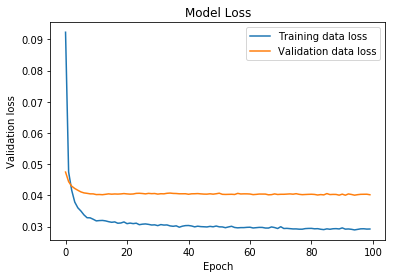

In [58]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [59]:
# Prediction Time !!!!
yhat_cnn = model_cnn.predict(X_test)
mse_cnn = mean_squared_error(y_test, yhat_cnn)
rmse_cnn = sqrt(mse_cnn)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#models.loc['rmse','CNN_many_to_many'] = np.sqrt(mean_squared_error(y_test, yhat_cnn))
models.loc['MAPE','CNN_many_to_many'] = mean_absolute_percentage_error(y_test, yhat_cnn)
models.loc['MAE','CNN_many_to_many'] = mean_absolute_error(y_test, yhat_cnn)*100




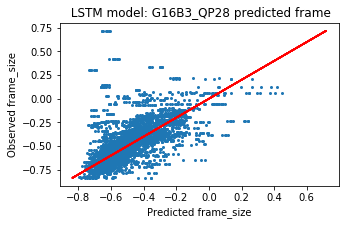

In [60]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(model_lstm.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title(' LSTM model: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

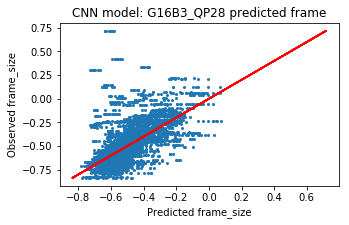

In [61]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(model_cnn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('CNN model: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# single-step models

***Single-step LSTM model***

In [62]:
#import data
data2 = pd.read_csv("../VIDEO TRAFFIC/FINAL comparison -benchmark models/data/nbc news G16B3-QP = 10-1.csv",
                  names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])

In [63]:
data2.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,16,533.33333,I,237784,52.353,52.474,52.951
1,13,433.33333,B,191888,48.114,49.612,50.446
2,14,466.66667,B,198992,48.003,49.608,50.231
3,15,500.00000,B,136112,48.290,50.312,51.118
4,20,666.66667,P,296416,49.951,50.910,51.201


In [64]:
data2.dropna(0,inplace= True)

In [65]:
#drop decoded frame column
data2.drop(('decoded_frame'), axis=1, inplace=True)

data2.drop(('x'), axis=1, inplace=True)
data2.drop(('y'), axis=1, inplace=True)
data2.drop(('z'), axis=1, inplace=True)

In [66]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data2['video_frame'])
print(list(le.classes_))
data2['video_frame'] = le.transform(data2['video_frame'])

['B', 'I', 'P']


In [67]:
data2.head(5)

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
1,433.33333,0,191888
2,466.66667,0,198992
3,500.00000,0,136112
4,666.66667,2,296416


In [68]:
# data labels
labels_index = { "B" : 0, "I" : 1, "P" : 2} 

In [69]:
indexNames1 = data2[data2['video_frame'] == 0 ].index

# Delete these row indexes from dataFrame
data2.drop(indexNames1 , inplace=True)

In [70]:
data2.head()

,arrival_time,video_frame,frame_size
0,533.33333,1,237784
4,666.66667,2,296416
8,800.00000,2,289312
12,933.33333,2,288384
16,1066.66667,1,259272


In [71]:
data2.frame_size.dropna(0, inplace=True)

In [72]:
dataset2 = data2.frame_size.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset2.shape

(2962,)

In [73]:
dataset2 = pd.DataFrame(dataset2)
print(dataset2.shape)

(2962, 1)


In [74]:
# *****************split into train and test sets********************

test_split = int(len(dataset2) * 0.8)

train2 = dataset2[:test_split]
test2 = dataset2[test_split:]

In [75]:
#********Data normalization**************************

scaler = MinMaxScaler(feature_range=(-1, 1))

train2 = scaler.fit_transform(train2)
test2 = scaler.transform(test2)

In [76]:
# ******************frame a lagged sequence problem*************

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 16
X_train, y_train = create_dataset(train2, look_back)
X_test, y_test = create_dataset(test2, look_back)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2352, 16) (2352,)
(576, 16) (576,)


In [77]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train',X_train.shape)
print('X_test', X_test.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

X_train (2352, 16, 1)
X_test (576, 16, 1)


In [78]:
#********************Build Model****************************

def single_step_lstm_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(128, input_shape=(look_back,1),kernel_regularizer=regularizers.l2(0.001)
                ))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(64, kernel_regularizer=regularizers.l2(0.001)))
    #model.add(tf.keras.layers.Dropout(rate=0.20))
    #model.add(LSTM(128, kernel_initializer='glorot_uniform',activation='relu'))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mse')
      
    return model

In [79]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]

single_step_model_lstm = single_step_lstm_model()


history_lstm_single_step = single_step_model_lstm.fit(X_train, y_train, batch_size = 32,validation_split=0.2,
                                                      epochs =100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_3 (UnifiedLSTM) (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Train on 1881 samples, validate on 471 samples
Epoch 1/100
1881/1881 [==============================] - 1s 614us/sample - loss: 0.0719 - val_loss: 0.0464
Epoch 2/100
1881/1881 [==============================] - 1s 306us/sample - loss: 0.0561 - val_loss: 0.0457
Epoch 3/100
1881/1881 [==============================] - 1s 308us/sample - loss: 0.0561 - val_loss: 0.0454
Epoch 4/100
1881/1881 [==============================] - 1s 314us/sample - loss: 0.0560 - val_loss: 0.0452
Epoch 5/100
1881/1881 [==============

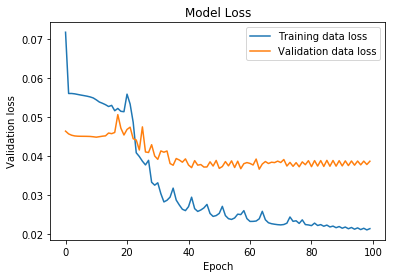

In [80]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_lstm_single_step.history['loss'])
plt.plot(history_lstm_single_step.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [81]:
# convert 1 D to 2D array
y_train = y_train.reshape((y_train.shape[0], 1))
#print(test_y.shape)

# convert 1 D to 2D array
y_test = y_test.reshape((y_test.shape[0], 1))
#print(test_y.shape)

In [82]:
# Prediction Time !!!!

yhat_lstm_single_step = single_step_model_lstm.predict(X_test)

mse_lstm_single_step = mean_squared_error(y_test, yhat_lstm_single_step)
rmse_lstm = sqrt(mse_lstm_single_step)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#models.loc['rmse','LSTM_many_to_one'] = np.sqrt(mean_squared_error(y_test, yhat_lstm_single_step))
models.loc['MAPE','LSTM_many_to_one'] = mean_absolute_percentage_error(y_test, yhat_lstm_single_step)
models.loc['MAE','LSTM_many_to_one'] = mean_absolute_error(y_test, yhat_lstm_single_step)*100

***Single-step CNN model***

In [83]:
#********************Build Model****************************

def single_step_cnn_model():
    
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, input_shape=(look_back,1)
                    ))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
      
    return model

In [84]:
single_step_model_cnn = single_step_cnn_model()

history_cnn_single_step = single_step_model_cnn.fit(X_train, y_train, batch_size = 32,validation_split=0.2,
                                                    epochs = 100, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 896)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 897       
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
Train on 1881 samples, validate on 471 samples
Epoch 1/100
1881/1881 [==============================] - 0s 189us/sampl

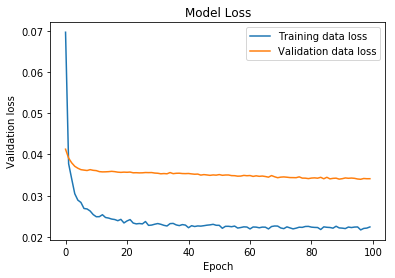

In [85]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_cnn_single_step.history['loss'])
plt.plot(history_cnn_single_step.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [86]:
# Prediction Time !!!!

yhat_cnn_single_step = single_step_model_cnn.predict(X_test)

#mse_cnn = mean_squared_error(y_test, yhat_cnn_single_step)
#rmse_cnn = sqrt(mse_cnn)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#models.loc['rmse','CNN_many_to_one'] = np.sqrt(mean_squared_error(y_test, yhat_cnn_single_step))
models.loc['MAPE','CNN_many_to_one'] = mean_absolute_percentage_error(y_test, yhat_cnn_single_step)
models.loc['MAE','CNN_many_to_one'] = mean_absolute_error(y_test, yhat_cnn_single_step)*100




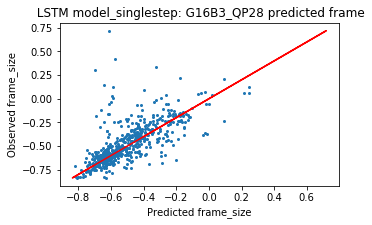

In [87]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(single_step_model_lstm.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title(' LSTM model_singlestep: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

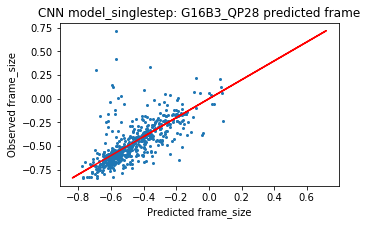

In [88]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(single_step_model_cnn.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('CNN model_singlestep: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# Visualization

In [89]:
models

,seq2seq,LSTM_many_to_many,CNN_many_to_many,LSTM_many_to_one,CNN_many_to_one
MAPE,74.5321,69.5776,74.7589,65.5973,59.3991
MAE,13.9568,10.6763,10.8238,9.64485,9.23528


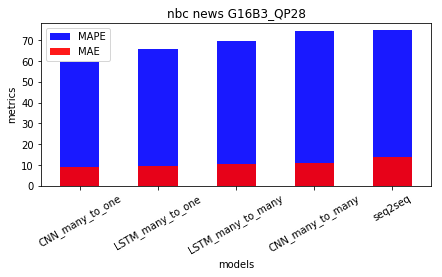

In [90]:
import seaborn as sns
import matplotlib
fig, ax = plt.subplots(figsize=(7,3))

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax2 = ax.twinx()   # create another axes that shares teh same x-axis as ax
bar_width = 0

#sns.set_style("dark")
#matplotlib.style.use('fivethirtyeight')


models.loc['MAPE'].sort_values().plot(kind='bar', ax=ax,color ='b', alpha=0.9)
models.loc['MAE'].sort_values().plot(kind='bar', ax=ax, color='r', alpha=0.9)
ax.set_title('nbc news G16B3_QP28');
ax.set_xlabel('models')
#ax2.set_ylabel('mape')
ax.set_ylabel('metrics');
ax.tick_params(axis='x', rotation=30)

#plt.xticks(rotation=30, horizontalalignment="center")


plt.legend(loc='best')
plt.show()

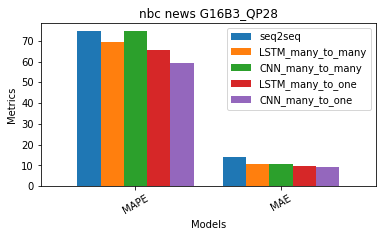

In [91]:

models.plot(kind='bar', width=0.8, figsize=(6,3))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title('nbc news G16B3_QP28');
plt.xlabel('Models')
plt.ylabel('Metrics')
#ax2.set_ylabel('mape')

plt.show()

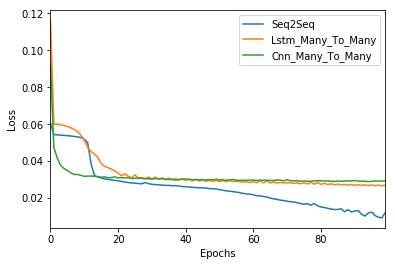

In [92]:
# Loss of the model

def plot_history(histories, key=  'loss'):
  #plt.figure(figsize=(15,10))
    
  for name, history in histories:
    plt.plot(history.epoch, history.history[key],
             label=name.title())
    
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.xlim([0,max(history.epoch)])


plot_history([('seq2seq', history),
              ('LSTM_many_to_many', history_lstm),
         
             ('CNN_many_to_many', history_cnn)])

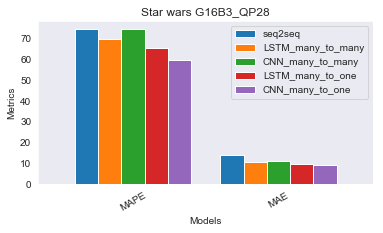

In [93]:
import seaborn as sns
sns.set_style("dark")


models.plot(kind='bar', width=0.8, figsize=(6,3))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title('Star wars G16B3_QP28');
plt.xlabel('Models')
plt.ylabel('Metrics')
#ax2.set_ylabel('mape')

plt.show()